# **Projet MACS207b**  - Filtrage
- Rendu le 10/06/2022

**Timothée LY, Louis PERSONNAZ**

# 1 - Présentation du problème

**Hypothèses :**

2 processus de Poisson indépendants $N_a$ et $N_b$, on observe $N_a$ puis $N_b$ après $\tau$
- $\tau \sim \mathcal{E}(\mu)$ avec $\mu = 0.2$ et $\tau$ indépendant de $N_a$, $N_b$
- $a = 5$ et $b = 10$

**But :** on veut estimer $\tau$ à travers l'observation des instants de saut du processus ponctuel "concaténé" $N$

**Notations :** $\tau$ a pour densité $f$ et fonction de répartition $F$ 

# 2 - Résolution et implémentation

On calcule la fonction $h$ donnée par :
$$h(s) = \dfrac{f(s)}{1-F(s)}$$

Pour une loi exponentielle d'intensité $\mu$: 

$\forall s \in \mathbb{R}, \ f(s) = \mu e^{-\mu s} \mathbb{1}_{\mathbb{R}^+}(s)$

$\forall s \in \mathbb{R}, \ F(s) = (1 - e^{-\mu s}) \mathbb{1}_{\mathbb{R}^+}(s)$

d'où l'on tire

$$
\begin{align*}
\forall s \in \mathbb{R}^+, \quad h(s)
&= \dfrac{ \mu e^{-\mu s}}{1-(1 - e^{-\mu s})} \\
&= \dfrac{ \mu e^{-\mu s}}{e^{-\mu s}} \\
&= \mu
\end{align*}
$$

<u> Application numérique :</u>  $h(s) = 0.2 \, \mathbb{1}_{s \ge 0}$

### Imports

In [90]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
sns.set()
sns.set_palette("hls", 10)

### Graine (pour reproductibilité)

In [157]:
seed = 91120

### Approche théorique

In [158]:
mu = 0.2
h = lambda s : mu if s > 0 else 0
a = 5
b = 10

In [159]:
rng = np.random.default_rng(seed)

Z = lambda t, tau : 1 if (tau <= t) else 0
N = lambda a, b, t, tau : (a + (b-a) * Z(t, tau)) * t

In [160]:
def poisson_proc(lmbda, orig, horiz, rng):
    """
    génère des instants d'arrivée d'un processus de Poisson
    lmbda: intensité
    orig: origine des temps
    horiz: horizon des temps
    """  
    arrivals = []
    t = orig
    while t < horiz:
        t = t - np.log(rng.random()) / lmbda
        arrivals.append(t)
    
    return np.sort(arrivals[:-1])   

In [161]:
def trajectory(a, b, beg, end, rng, n=1000):
    """
    affiche la trajectoire d'une observation aléatoire
    a, b: intensités
    beg, end: bornes des temps
    n: nombre de points pour l'affichage
    """
    tau = beg + rng.exponential(1/mu) # tirer un tau aléatoire dans [beg, +inf[
    end = max(end, 1 + np.ceil(tau))      # éloigner l'horizon si tau trop grand
    # générer les temps d'arrivée avant et après tau
    arrivals = np.concatenate((poisson_proc(a, beg, tau, rng),
                               poisson_proc(b, tau, end, rng)))
    
    plt.figure(figsize=(10, 5))
    plt.step(arrivals, np.arange(arrivals.size))
    plt.axvline(tau, linestyle=':', c='olivedrab')
    plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
    plt.xlim(beg, max(end, tau))
    plt.title(fr"Une trajectoire avec $\tau =${tau:.2f}")
    plt.ylabel(r"$N(t)$")
    plt.xlabel(r"$t$")
    plt.show()
    
    return beg, end, arrivals, tau

In [162]:
beg, end = 0, 10

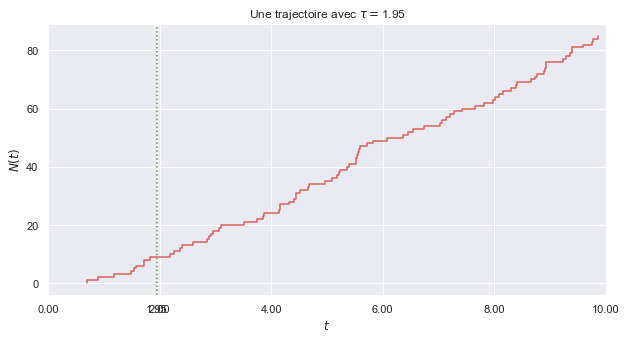

In [163]:
beg, end, arrivals, tau = trajectory(a, b, beg, end, rng)

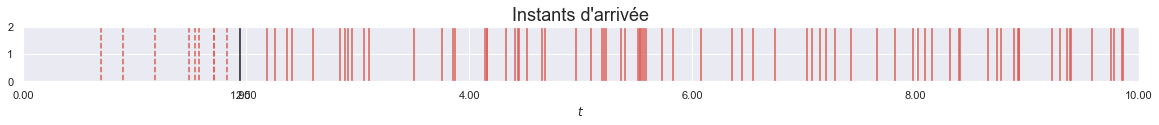

In [164]:
plt.figure(figsize=(20, 1))
plt.eventplot(arrivals[arrivals < tau].flatten(), linelengths=2, linestyles='dashed')
plt.eventplot(arrivals[arrivals > tau].flatten(), linelengths=2, linestyles='solid')
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title("Instants d'arrivée", fontsize=18)
plt.show()

On peut montrer que (cf. exercice 2.2 — Détection de changement de régime du poly) :
- les instants de saut de $Z$ sont ceux de $N$
-
$$\forall t \in ]T_n, T_{n+1}[, \quad \hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t [h(s) - (b-a)\hat{Z}(s)] (1 - \hat{Z}(s)) \, \mathrm{d} s$$
d'où
$$\forall t \in ]T_n, T_{n+1}[, \quad \hat{Z}'(t) = [h(t) - (b-a)\hat{Z}(t)] (1 - \hat{Z}(t))$$
-
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a) \hat{Z}(T_n^-) (1-\hat{Z}(T_n^-))}{a + (b-a) \hat{Z}(T_n^-)}$$

In [165]:
derivative = lambda z, t : (h(t) - (b-a)*z) * (1-z)

In [166]:
def flatten_to_array(l):
    t = []
    for e in l:
        if isinstance(e, float):
            t.append(e)
        if isinstance(e, np.ndarray):
            t += e.tolist()
    return np.array(t)

In [167]:
def saut(ZTn_, a, b):
    return (b-a) * ZTn_ * (1 - ZTn_) / (a + (b-a) * ZTn_)

In [168]:
def Z_hat(arrivals, beg, end):
    """
    calcule l'estimation de Z à partir de l'observation des sauts
    """
    m = arrivals.size
    ts = []     # temps
    Z_hats = [] # valeurs de Z_hat
    z0 = 0      # valeur initiale
    
    # segment [beg, T_0]
    n_points = int(np.ceil(50 * max(a,b) * arrivals[0]))
    t = np.linspace(0, arrivals[0], n_points, endpoint=False)
    ts.append(t)
    Z_hats.append(odeint(derivative, z0, t).ravel())
    ts.append(arrivals[0]) # rajouter ce temps exclu ci-dessus
    Z_hats.append(Z_hats[-1][-1] + saut(Z_hats[-1][-1], a, b)) # prendre pour ZTn_ la dernière valeur estimée
    
    for n in range(m-1):
        # segment [T_n, T_{n+1}]
        n_points = int(np.ceil(50 * max(a,b) * (arrivals[n+1] - arrivals[n])))
        t = np.linspace(arrivals[n], arrivals[n+1], n_points, endpoint=False)
        ts.append(t)
        Z_hats.append(odeint(derivative, Z_hats[-1], t).ravel())
        ts.append(arrivals[n+1])
        Z_hats.append(Z_hats[-1][-1] + saut(Z_hats[-1][-1], a, b))
        
    # segment [T_{m-1}, end]
    n_points = int(np.ceil(50 * max(a,b) * (end - arrivals[-1])))
    t = np.linspace(arrivals[-1], end, n_points, endpoint=True)
    ts.append(t)
    Z_hats.append(odeint(derivative, Z_hats[-1], t).ravel())
    
    return flatten_to_array(ts), flatten_to_array(Z_hats)

In [169]:
ts, Z_hats = Z_hat(arrivals, beg, end)

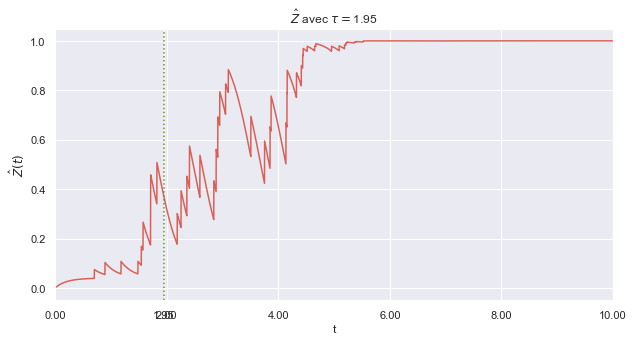

In [170]:
plt.figure(figsize=(10, 5))
plt.plot(ts, Z_hats)
plt.axvline(tau, linestyle=':', c='olivedrab')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.title(fr"$\hat{{Z}}$ avec $\tau =${tau:.2f}")
plt.ylabel(r'$\hat{Z}(t)$')
plt.xlabel("t")
plt.show()

### Approche par Machine Learning : K-means

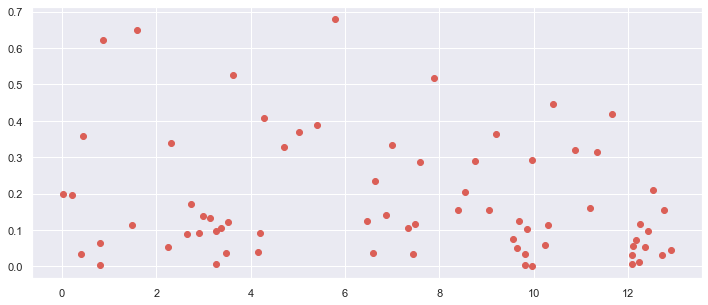

In [141]:
plt.figure(figsize=(12, 5))
waits = arrivals[1:] - arrivals[:-1]
plt.scatter(arrivals[:-1], waits)
plt.show()

In [142]:
n_clusters = 5
foo = np.stack((arrivals[:-1], waits), axis=1)
bar = KMeans(n_clusters=n_clusters, n_init=30, random_state=seed)
bar.fit(foo)

KMeans(n_clusters=5, n_init=30, random_state=535363)

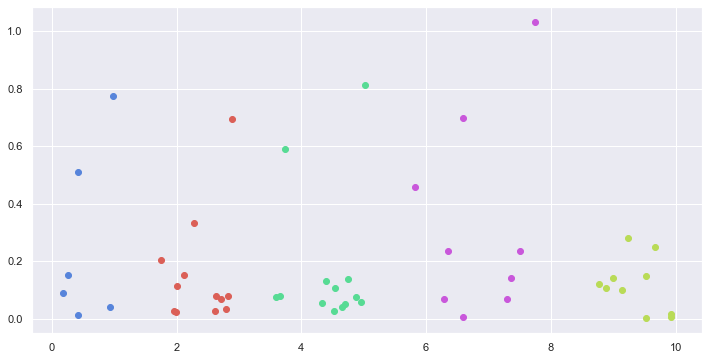

In [48]:
palette = sns.color_palette(palette='hls', n_colors=n_clusters) # palette de couleurs
plt.figure(figsize=(12, 6))
for n in range(n_clusters):
    plt.scatter(arrivals[:-1][bar.labels_ == n],
                waits[bar.labels_ == n],
                color=palette[n])

<hr>

In [49]:
n_clusters = 10

In [50]:
kmeans = KMeans(n_clusters=n_clusters, n_init=30, random_state=seed)
kmeans.fit(arrivals.reshape(-1, 1))

KMeans(n_clusters=10, n_init=30, random_state=1789)

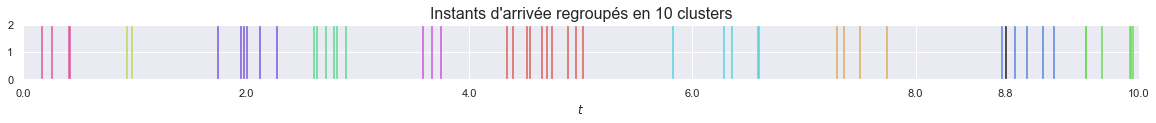

In [51]:
palette = sns.color_palette(palette='hls', n_colors=n_clusters) # palette de couleurs
#sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'w'})
plt.figure(figsize=(20, 1))
for n in range(n_clusters):
    plt.eventplot(arrivals[kmeans.labels_ == n],
                  linelengths=2,
                  colors=palette[n])
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title(f"Instants d'arrivée regroupés en {n_clusters} clusters", fontsize=16)
plt.show()

In [52]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
kmeans_counts = KMeans(n_clusters=2, random_state=seed)
kmeans_counts.fit(counts.reshape(-1, 1))
selected_labels = unique[kmeans_counts.labels_ == 0]

In [53]:
min0, max0, min1, max1 = end, beg, end, beg
for n in range(n_clusters):
    if kmeans_counts.labels_[n] == 1:
        if np.max(arrivals[kmeans.labels_ == n]) > max1:
            max1 = np.max(arrivals[kmeans.labels_ == n])
        if np.min(arrivals[kmeans.labels_ == n]) < min1:
            min1 = np.min(arrivals[kmeans.labels_ == n])
    if kmeans_counts.labels_[n] == 0:
        if np.max(arrivals[kmeans.labels_ == n]) > max0:
            max0 = np.max(arrivals[kmeans.labels_ == n])
        if np.min(arrivals[kmeans.labels_ == n]) < min0:
            min0 = np.min(arrivals[kmeans.labels_ == n])
sorted_bounds = np.sort([min0, max0, min1, max1])
tau_kmeans = (sorted_bounds[1] + sorted_bounds[2]) / 2

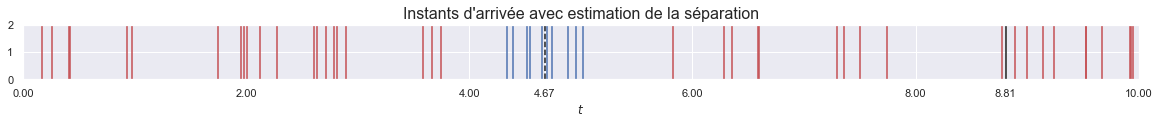

In [54]:
palette = sns.color_palette(palette='hls', n_colors=n_clusters) # palette de couleurs
#sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'w'})
plt.figure(figsize=(20, 1))
for n in range(n_clusters):
    if kmeans_counts.labels_[n] == 1:
        plt.eventplot(arrivals[kmeans.labels_ == n],
                      linelengths=2,
                      colors='b')
    else:
        plt.eventplot(arrivals[kmeans.labels_ == n],
                      linelengths=2,
                      colors='r')
plt.axvline(tau_kmeans, linestyle='--', c='k')
plt.xticks(list(plt.xticks()[0]) + [tau_kmeans]) # ajouter 1 tick à l'abscisse tau
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title(f"Instants d'arrivée avec estimation de la séparation", fontsize=16)
plt.show()

<hr>

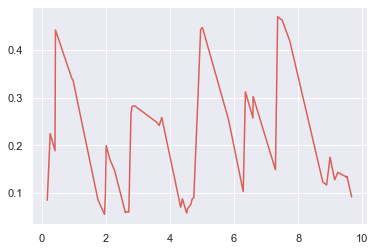

In [55]:
means = arrivals[1:] - arrivals[:-1]
pad = np.concatenate(([0],means,[0]))
smooth = (means[:-2]+means[1:-1]+means[2:])/3
concat = np.array([[smooth[i],arrivals[i]] for i in range(len(smooth))])
concat.shape
plt.plot(arrivals[:-3],smooth)

J'ai essayé d'applanir le signal mais ça a rien donné de fou. Si l'on passe arrivals ou concat à KMeans, ça donne un truc propre genre [00000....11111] mais le tau estimé est totalement faux.
Si on passe la moyenne ou le smoothed c'est pas tranché genre [000001001100111110111101]? ALED

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


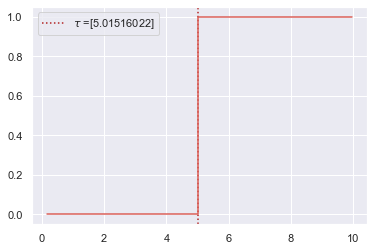

In [56]:
kmeans = KMeans(n_clusters=2, n_init=1, init='k-means++').fit(arrivals.reshape(-1,1))

print(kmeans.labels_)
tau_ = np.where(kmeans.labels_[:-1] != kmeans.labels_[1:])[0]

plt.axvline(arrivals[tau_], linestyle=':', c='firebrick', label = r'$\tau$ =' + str(arrivals[tau_]))
plt.step(arrivals, kmeans.labels_)
plt.legend()
plt.show()

It yields no conclusive result. However, K-means clustering is not efficient on 1D dataset and should arguably be used on multivariate data instead. 